In [2]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math
from scipy import stats
import numpy as np

trips = Table.read_table('trip.csv')

Here is an hypothesis about bike trips:

> "There is a negative association between urban density and duration of bike trips.  Stations in dense urban areas with lots of commuters are very highly-traveled, and commuters tend to take very short trips.  Stations in less-urban areas have fewer trips (since these areas are less populated), but a larger proportion of these are longer excursions.  Therefore, there is a negative *non-causal* association between station popularity and average trip duration."

How might we use data to test that hypothesis?

A scatter plot of the stations, showing trip count against average duration, would be a fine place to start.  To do that, we'll need a table that looks something like this, but filled in:

|Start Station|Average trip duration|Number of trips|
|-|-|-|
|||||

We can begin by using `group` to identify the most highly used Start Station:

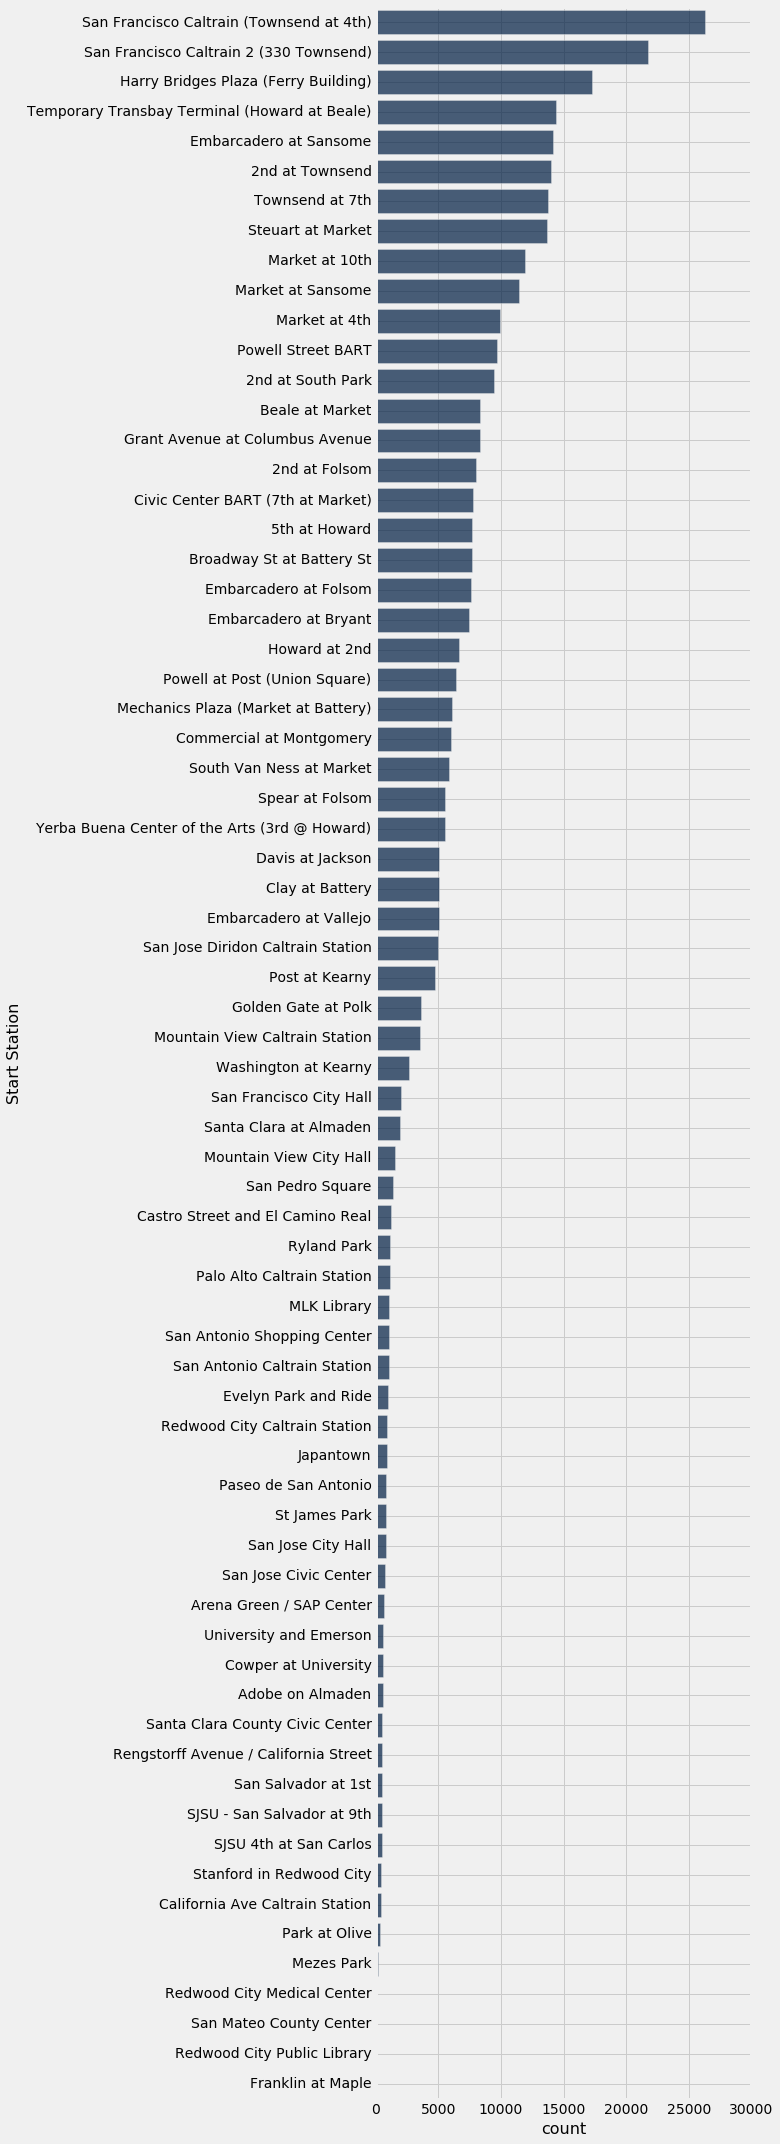

In [4]:
starts = trips.group('Start Station').sort('count', descending=True)
starts.barh("Start Station", "count")

The largest number of trips started at the Caltrain Station on Townsend and 4th in San Francisco. Many trips also start at the Ferry Building, which is the first BART station for passengers from the East Bay. People take the train into the city, and then use a shared bike to get to their next destination.

We can again use `group` to compute the average (mean) duration of trips from each station:

In [5]:
duration_by_station = trips.select('Start Station', 'Duration')\
                           .group('Start Station', np.mean)\
                           .sort("Duration mean")\
                           .relabeled("Duration mean", "Average trip duration")
duration_by_station

Start Station,Average trip duration
2nd at Folsom,543.396
Temporary Transbay Terminal (Howard at Beale),612.622
Townsend at 7th,626.133
San Francisco Caltrain 2 (330 Townsend),660.838
2nd at South Park,691.807
Howard at 2nd,697.077
2nd at Townsend,719.057
Beale at Market,736.002
Broadway St at Battery St,787.533
Embarcadero at Folsom,788.385


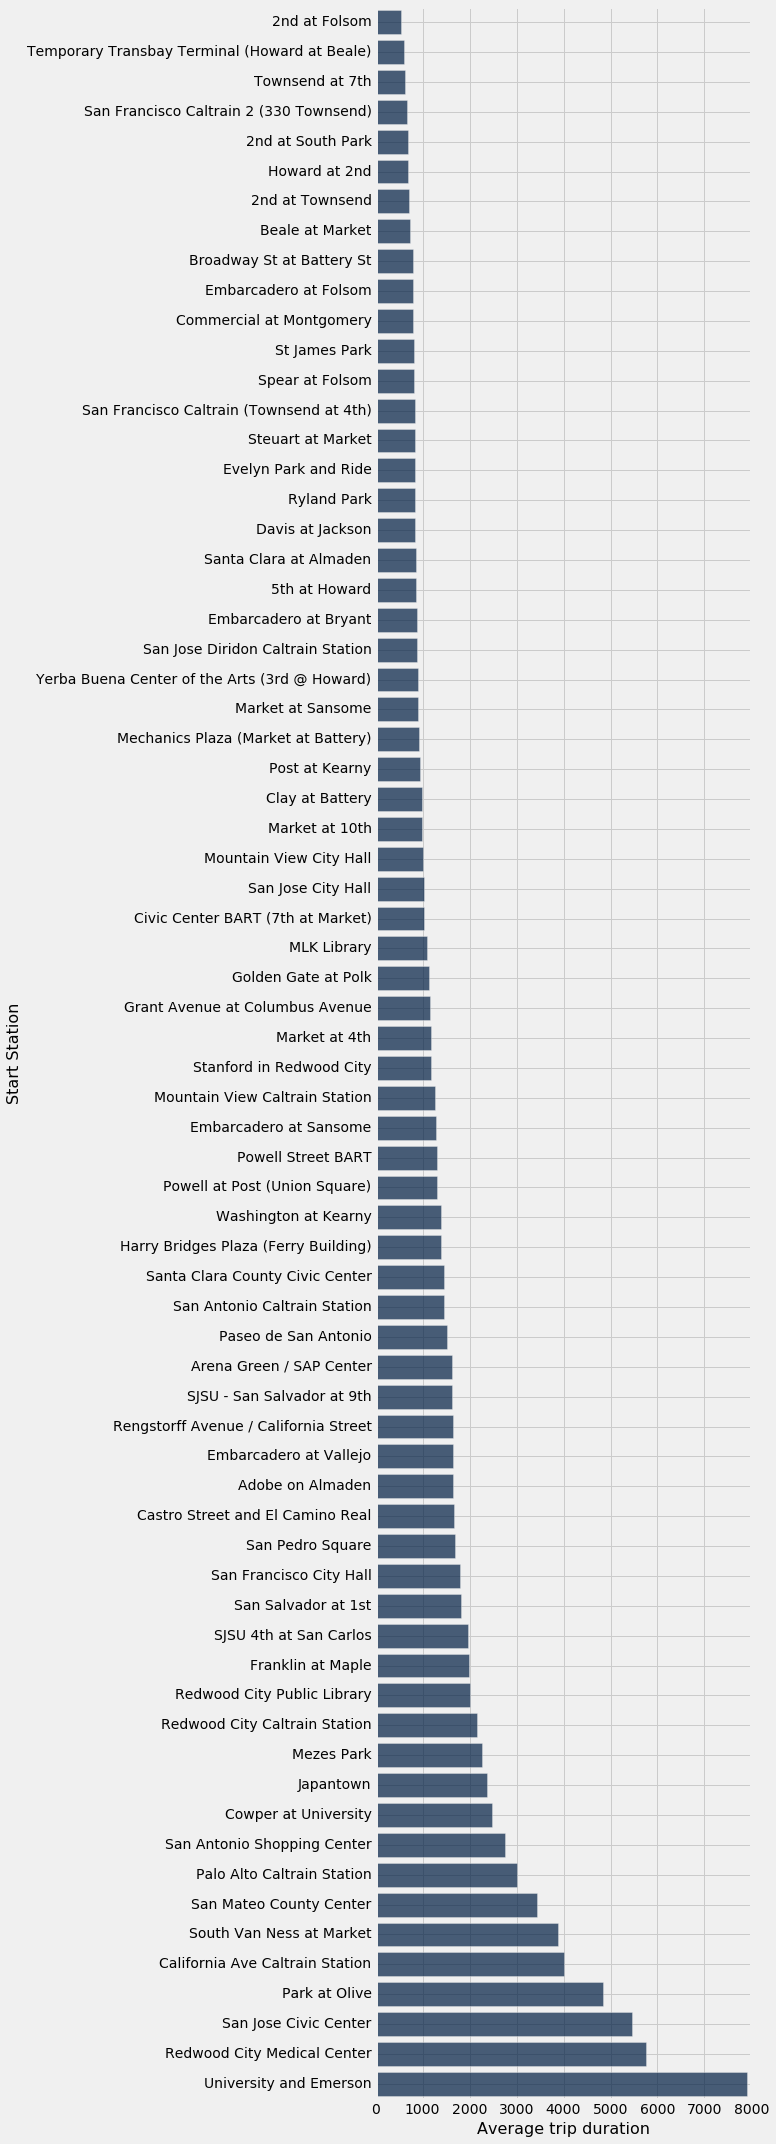

In [6]:
duration_by_station.barh("Start Station", "Average trip duration")

### Putting the data together
Now we will need to put both the trip count and average trip duration in the same table.  Later, you may learn about a method called `join` that can perform tasks like this.  However, we can do it with `apply` by following these steps:

1. Write a function that takes a single station name and returns the trip count for that station.  It will use `where` to look up the trip count in the `starts` table we previously computed.
2. `apply` this function to the "Start Station" column in `duration_by_station`.
3. Add the resulting array of trip counts to `duration_by_station` as a new column.

In [91]:
# Step one:
def find_trip_count(station_name):
    return starts.where("Start Station", are.equal_to(station_name)).column("count").item(0)

# Step two:
counts = duration_by_station.apply(find_trip_count, "Start Station")

# Step three:
durations_and_counts = duration_by_station.with_column("Number of trips", counts)
durations_and_counts

Start Station,Average trip duration,Number of trips
2nd at Folsom,543.396,7999
Temporary Transbay Terminal (Howard at Beale),612.622,14436
Townsend at 7th,626.133,13752
San Francisco Caltrain 2 (330 Townsend),660.838,21758
2nd at South Park,691.807,9469
Howard at 2nd,697.077,6660
2nd at Townsend,719.057,14026
Beale at Market,736.002,8359
Broadway St at Battery St,787.533,7676
Embarcadero at Folsom,788.385,7596


Now we can use `scatter`.

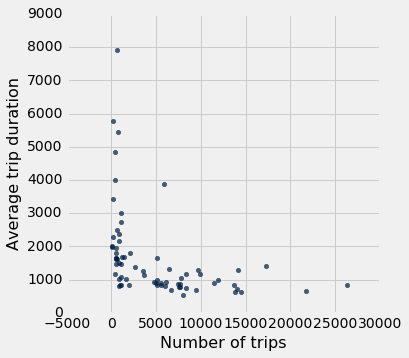

In [93]:
durations_and_counts.scatter("Number of trips", "Average trip duration")

For stations with a very small number of trips, the average trip duration is sometimes quite high.  Otherwise, the graph is somewhat flat, with perhaps a slight downward trend.

This establishes the second part of our hypothesis: there is a negative association between station popularity (number of trips) and average trip duration.  To gather evidence for the first part of our hypothesis -- that there is a negative assocation between urban density and average trip duration -- we need to verify that the stations with high average trip durations are near urban areas.

We could use the optional `labels` argument to label the points in the plot.

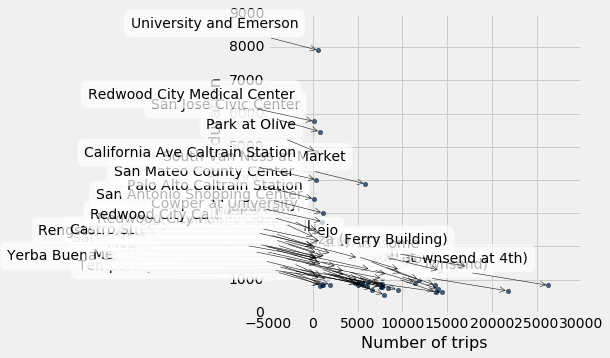

In [94]:
durations_and_counts.scatter("Number of trips", "Average trip duration", labels="Start Station")

Unfortunately, even if you happen to know the Bay Area well, there are too many points to get an overall picture of where the low-trip stations tend to be.